In [7]:
import pandas as pd
import numpy as np
import os

# --- CONFIGURAÇÃO ---
INPUT_FILE = '../data/processed/painel_mei_rf_anual.parquet'
OUTPUT_FILE = '../data/processed/painel_mei_balanceado_2016_2024.parquet'

def balancear_dados(df):
    print("📊 [1/4] Criando setor Total (Soma dos fluxos)...")
    
    # 1. Gerar o Total a partir dos fluxos de entrada/saída
    # Agrupamos por município e ano, ignorando o setor original
    df_total = df.groupby(['mun', 'ano'], as_index=False)[['entradas', 'saidas']].sum()
    df_total['setor'] = 'Total'
    
    # Empilha o Total com os setores originais
    df = pd.concat([df, df_total], ignore_index=True)

    print("⚖️ [2/4] Iniciando balanceamento do painel (2016-2024)...")
    
    todos_muns = df['mun'].unique()
    # Adicionado 'Total' na lista explicitamente
    todos_setores = ['Agro', 'Industria', 'Servicos', 'Setor Publico', 'Total']
    todos_anos = np.arange(2016, 2025)
    
    # 2. Criar o MultiIndex (Produto Cartesiano)
    index_completo = pd.MultiIndex.from_product(
        [todos_muns, todos_setores, todos_anos],
        names=['mun', 'setor', 'ano']
    )
    
    # 3. Reindexar preenchendo lacunas com 0
    df_balanceado = (df.set_index(['mun', 'setor', 'ano'])
                     .reindex(index_completo, fill_value=0)
                     .reset_index())
    
    # 4. Recalcular Estoque Acumulado
    print("📈 [3/4] Recalculando estoques acumulados por setor e total...")
    df_balanceado = df_balanceado.sort_values(['mun', 'setor', 'ano'])
    
    # O estoque acumulado agora funciona perfeitamente para setores e para o total
    df_balanceado['estoque_mei'] = (
        df_balanceado.groupby(['mun', 'setor'])['entradas'].cumsum() - 
        df_balanceado.groupby(['mun', 'setor'])['saidas'].cumsum()
    )
    
    # 5. Logaritmo para DiD
    print("🧪 [4/4] Aplicando log_estoque...")
    df_balanceado['log_estoque'] = np.log1p(df_balanceado['estoque_mei'].clip(lower=0))
    
    return df_balanceado

def main():
    if not os.path.exists(INPUT_FILE):
        print(f"❌ Erro: Arquivo {INPUT_FILE} não encontrado.")
        return

    # Carregando dados (garantindo que mun seja int para o csdid)
    df = pd.read_parquet(INPUT_FILE)
    df['mun'] = df['mun'].astype(int)
    
    # Executando balanceamento
    df_final = balancear_dados(df)
    
    # Salvando
    df_final.to_parquet(OUTPUT_FILE, index=False)
    print(f"✅ Painel balanceado e totalizado salvo com {len(df_final):,} linhas.")
    print(f"📂 Caminho: {OUTPUT_FILE}")

if __name__ == "__main__":
    main()

📊 [1/4] Criando setor Total (Soma dos fluxos)...
⚖️ [2/4] Iniciando balanceamento do painel (2016-2024)...
📈 [3/4] Recalculando estoques acumulados por setor e total...
🧪 [4/4] Aplicando log_estoque...
✅ Painel balanceado e totalizado salvo com 250,695 linhas.
📂 Caminho: ../data/processed/painel_mei_balanceado_2016_2024.parquet


In [18]:
df = pd.read_parquet('../data/processed/rais_painel_balanceado.parquet')

In [19]:
erros = verificar_balanceamento(df)

--- Relatório de Balanceamento ---
Municípios: 5570 | Setores: 4 | Anos: 9
Tamanho Atual: 200,520
Tamanho Esperado: 200,520
✅ O painel está perfeitamente balanceado.


In [15]:
import pandas as pd
import numpy as np
import os
import gc

# --- CONFIGURAÇÃO DE CAMINHOS ---
INPUT_FILE = '../data/raw/rais_agregada_municipio_setor.parquet'
OUTPUT_DIR = '../data/processed'
OUTPUT_FILE = os.path.join(OUTPUT_DIR, 'rais_painel_balanceado.parquet')

def balancear_painel_final(df):
    """
    Garante que cada município tenha os 4 setores em todos os 9 anos.
    """
    print("⚖️  [1/2] Criando grid completo (Município x Setor x Ano)...")
    
    # 1. Definição dos eixos
    todos_muns = df['id_municipio'].unique()
    todos_sets = ['Agro', 'Industria', 'Servicos', 'Setor Publico']
    todos_anos = sorted(df['ano'].unique())
    
    # 2. Criar o MultiIndex para o Produto Cartesiano
    index_completo = pd.MultiIndex.from_product(
        [todos_muns, todos_sets, todos_anos], 
        names=['id_municipio', 'setor', 'ano']
    )
    
    # 3. Reindexar (Preenche lacunas com zero)
    print("⚙️  [2/2] Reindexando e calculando log_estoque...")
    # Removendo nome_municipio temporariamente para evitar duplicidade no reindex
    df_balanceado = (df.set_index(['id_municipio', 'setor', 'ano'])
                     .reindex(index_completo, fill_value=0)
                     .reset_index())
    
    # 4. Recuperar nomes dos municípios
    nomes = df[['id_municipio', 'nome_municipio']].drop_duplicates()
    df_balanceado = df_balanceado.drop(columns=['nome_municipio'], errors='ignore').merge(nomes, on='id_municipio', how='left')
    
    # 5. Variável Econométrica
    df_balanceado['log_estoque'] = np.log1p(df_balanceado['quantidade_vinculos_ativos'].astype(np.float32))
    
    return df_balanceado

def main():
    print("--- INICIANDO TRANSFORMAÇÃO RAIS ---")
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    if not os.path.exists(INPUT_FILE):
        print(f"❌ Erro: Arquivo {INPUT_FILE} não encontrado.")
        return

    # Leitura e Processamento
    df_raw = pd.read_parquet(INPUT_FILE)
    
    # Filtro preventivo (caso existam nulos ou setores 'Outros')
    df_raw = df_raw.dropna(subset=['id_municipio'])
    df_raw = df_raw[df_raw['setor'] != 'Outros']
    
    df_final = balancear_painel_final(df_raw)
    
    # Salvamento
    print(f"💾 Salvando painel balanceado ({len(df_final):,} linhas)...")
    df_final.to_parquet(OUTPUT_FILE, index=False, compression='snappy')
    
    del df_raw, df_final
    gc.collect()
    print("--- CONCLUÍDO COM SUCESSO ---")

if __name__ == "__main__":
    main()

--- INICIANDO TRANSFORMAÇÃO RAIS ---
⚖️  [1/2] Criando grid completo (Município x Setor x Ano)...
⚙️  [2/2] Reindexando e calculando log_estoque...
💾 Salvando painel balanceado (200,520 linhas)...
--- CONCLUÍDO COM SUCESSO ---


In [17]:
erros = verificar_balanceamento(df_final)

NameError: name 'df_final' is not defined

In [10]:
import requests
import pandas as pd
import os

# --- CONFIGURAÇÃO ---
OUTPUT_FILE = '../data/raw/pix_brasil_anual.parquet'
ANOS = [2020, 2021, 2022, 2023, 2024]

def baixar_mes(data_base):
    url = f"https://olinda.bcb.gov.br/olinda/servico/Pix_DadosAbertos/versao/v1/odata/TransacoesPixPorMunicipio(DataBase=@DataBase)?@DataBase='{data_base}'&$format=json"
    try:
        r = requests.get(url, timeout=60)
        return r.json().get('value', [])
    except:
        return []

def main():
    print("--- EXTRAÇÃO PIX ANUAL ---")
    lista_dfs = []

    for ano in ANOS:
        print(f"📅 Processando ano: {ano}")
        dados_ano = []
        
        for mes in range(1, 13):
            db = f"{ano}{mes:02d}"
            if int(db) < 202011: continue # PIX não existia
            
            print(f"  🚀 Baixando {db}...")
            dados_ano.extend(baixar_mes(db))
        
        if dados_ano:
            # Transforma em DF e agrega por ANO imediatamente (poupa RAM)
            df_temp = pd.DataFrame(dados_ano)
            df_temp['ano'] = ano
            
            # Agregamos as colunas de valor e quantidade por município/ano
            # Nota: Ajuste os nomes das colunas 'VL_Transacao' etc conforme o JSON da API
            df_agg = df_temp.groupby(['MunicipioIBGE', 'SiglaUF', 'ano']).agg({
                'Quantidade': 'sum',
                'Valor': 'sum'
            }).reset_index()
            
            lista_dfs.append(df_agg)

    # Consolidação Final
    df_final = pd.concat(lista_dfs, ignore_index=True)
    
    os.makedirs(os.path.dirname(OUTPUT_FILE), exist_ok=True)
    df_final.to_parquet(OUTPUT_FILE, index=False)
    print(f"✅ Painel PIX Anual salvo em: {OUTPUT_FILE}")

if __name__ == "__main__":
    main()

--- EXTRAÇÃO PIX ANUAL ---
📅 Processando ano: 2020
  🚀 Baixando 202011...
  🚀 Baixando 202012...


KeyError: 'MunicipioIBGE'

In [11]:
import pandas as pd
import numpy as np
import os

# --- CONFIGURAÇÃO DE CAMINHOS ---
INPUT_FILE = '../data/raw/test.parquet'
OUTPUT_DIR = '../data/processed'
OUTPUT_FILE = os.path.join(OUTPUT_DIR, 'rais_painel_balanceado.parquet')

def get_setor(c):
    """Mapeia a Divisão CNAE (2 dígitos) para grandes setores."""
    if 1 <= c <= 3: return 'Agro'
    if 5 <= c <= 33: return 'Industria'
    if c == 84: return 'Setor Publico'
    if 35 <= c <= 99: return 'Servicos'
    return 'Outros'

def processar_rais(df_rais_raw):
    """
    Transforma microdados da RAIS em agregados por Município/Setor/Ano.
    """
    print("   [1/3] Mapeando setores e tratando CNAE...")
    
    # Extração dos 2 dígitos da Divisão (CNAE de 5 dígitos // 1000)
    df = df_rais_raw.copy()
    df['cnae_prefix'] = (df['cnae_2'].fillna(0).astype(int) // 1000)
    df['setor'] = df['cnae_prefix'].apply(get_setor)
    
    print("   [2/3] Agregando estoque de vínculos por Município e Setor...")
    df_agg = (df.groupby(['id_municipio', 'setor', 'ano'])
                ['quantidade_vinculos_ativos'].sum()
                .reset_index())
    
    return df_agg

def rebalancear_painel(df_desbalanceado):
    """
    Garante que cada município tenha os 4 setores em todos os anos (preenche com zero).
    """
    print("   [3/3] Rebalanceando o painel (Produto Cartesiano)...")
    
    todos_municipios = df_desbalanceado['id_municipio'].unique()
    todos_setores = ['Agro', 'Industria', 'Servicos', 'Setor Publico']
    todos_anos = df_desbalanceado['ano'].unique()
    
    print(f"      -> Municípios: {len(todos_municipios)} | Setores: {len(todos_setores)} | Anos: {len(todos_anos)}")
    
    # Criando o esqueleto balanceado
    index = pd.MultiIndex.from_product(
        [todos_municipios, todos_setores, todos_anos], 
        names=['id_municipio', 'setor', 'ano']
    )
    df_esqueleto = pd.DataFrame(index=index).reset_index()
    
    # Merge com os dados reais
    df_balanceado = df_esqueleto.merge(df_desbalanceado, on=['id_municipio', 'setor', 'ano'], how='left')
    
    # Preenchimento de zeros e criação da variável logarítmica para o DID
    df_balanceado['quantidade_vinculos_ativos'] = df_balanceado['quantidade_vinculos_ativos'].fillna(0)
    df_balanceado['log_estoque'] = np.log1p(df_balanceado['quantidade_vinculos_ativos'])
    
    return df_balanceado

def main():
    print("--- INICIANDO ETL RAIS (HETEROGENEIDADE) ---")
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    if not os.path.exists(INPUT_FILE):
        print(f"ERRO: Arquivo de entrada não encontrado: {INPUT_FILE}")
        return

    print(f"Lendo arquivo: {INPUT_FILE}")
    df_raw = pd.read_parquet(INPUT_FILE)
    
    df_agg = processar_rais(df_raw)
    df_final = rebalancear_painel(df_agg)
    
    # Filtro opcional: remover categoria 'Outros' se não for do interesse da pesquisa
    df_final = df_final[df_final['setor'] != 'Outros']
    
    print(f"Salvando resultado em: {OUTPUT_FILE}")
    df_final.to_parquet(OUTPUT_FILE, index=False)
    print("--- CONCLUÍDO COM SUCESSO ---")

if __name__ == "__main__":
    main()

--- INICIANDO ETL RAIS (HETEROGENEIDADE) ---
Lendo arquivo: ../data/raw/test.parquet


MemoryError: Unable to allocate 1.82 GiB for an array with shape (3, 81642899) and data type object

In [9]:
5570*12*6


401040

In [ ]:
# 1. Extração dos 2 primeiros dígitos (Divisão) de forma segura
# Se o CNAE for 54321, vira 54. Se for 1234, vira 01.
df['cnae_prefix'] = (df['cnae_2'].fillna(0).astype(int) // 1000)

# 2. Mapeamento de Setores
def get_setor(c):
    if 1 <= c <= 3: return 'Agro'
    if 5 <= c <= 33: return 'Industria'
    if c == 84: return 'Setor Publico'
    if 35 <= c <= 99: return 'Servicos'
    return 'Outros'

df['setor'] = df['cnae_prefix'].apply(get_setor)

# 3. Agregação por Município, Setor e Ano
df_painel = (df.groupby(['id_municipio', 'setor', 'ano'])
             ['quantidade_vinculos_ativos'].sum()
             .reset_index())

import pandas as pd

def balancear_painel(df, col_id, col_setor, col_tempo, col_valor):
    """
    Garante que cada unidade (id/setor) exista em todos os períodos de tempo.
    """
    # 1. Cria o Produto Cartesiano (todas as combinações possíveis)
    grid = pd.MultiIndex.from_product(
        [df[col_id].unique(), df[col_setor].unique(), df[col_tempo].unique()],
        names=[col_id, col_setor, col_tempo]
    )
    
    # 2. Reindexa preenchendo o estoque vazio com 0
    df_balanced = (df.set_index([col_id, col_setor, col_tempo])
                   .reindex(grid, fill_value=0)
                   .reset_index())
    
    return df_balanced

# Como usar no seu projeto:
df_final = balancear_painel(df_painel, 'id_municipio', 'setor', 'ano', 'quantidade_vinculos_ativos')




In [4]:
import basedosdados as bd
import os
from dotenv import load_dotenv

def get_query(path):
    with open(path, 'r', encoding='utf-8') as f:
        return f.read()

def main():
    # 1. Configurações
    load_dotenv()
    billing_id = os.getenv("BILLING_ID")
    
    # Caminhos relativos a partir da raiz do projeto
    query_path = '../queries/rais.sql'
    output_path = '../data/raw/mortalidade_sim_filtrada.parquet'

    # 2. Execução
    print("⏳ Lendo query e baixando dados...")
    query = get_query(query_path)
    
    df = bd.read_sql(query=query, billing_project_id=billing_id)

    # 3. Salvamento
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df.to_parquet(output_path, index=False)
    print(f"✅ Dados de mortalidade salvos em: {output_path}")

if __name__ == "__main__":
    main()



⏳ Lendo query e baixando dados...
Downloading: 100%|██████████|
✅ Dados de mortalidade salvos em: ../data/raw/mortalidade_sim_filtrada.parquet


In [1]:
from csdid.att_gt import ATTgt
import pandas as pd
data = pd.read_csv("https://raw.githubusercontent.com/d2cml-ai/csdid/function-aggte/data/mpdta.csv")

In [2]:
out = ATTgt(yname = "lemp",
              gname = "first.treat",
              idname = "countyreal",
              tname = "year",
              xformla = f"lemp~1",
              data = data,
              ).fit(est_method = 'dr')

In [3]:
out.summ_attgt().summary2

,Group,Time,"ATT(g, t)",Post,Std. Error,[95% Pointwise,Conf. Band],
0,2004,2004,-0.0105,1,0.0240,-0.0757,0.0547,
1,2004,2005,-0.0704,1,0.0318,-0.1569,0.0160,
2,2004,2006,-0.1373,1,0.0367,-0.2371,-0.0374,*
3,2004,2007,-0.1008,1,0.0339,-0.1931,-0.0085,*
4,2006,2004,0.0065,0,0.0254,-0.0627,0.0757,
5,2006,2005,-0.0028,0,0.0201,-0.0574,0.0519,
6,2006,2006,-0.0046,1,0.0185,-0.0550,0.0458,
7,2006,2007,-0.0412,1,0.0199,-0.0953,0.0128,
8,2007,2004,0.0305,0,0.0144,-0.0087,0.0697,
9,2007,2005,-0.0027,0,0.0159,-0.0459,0.0404,


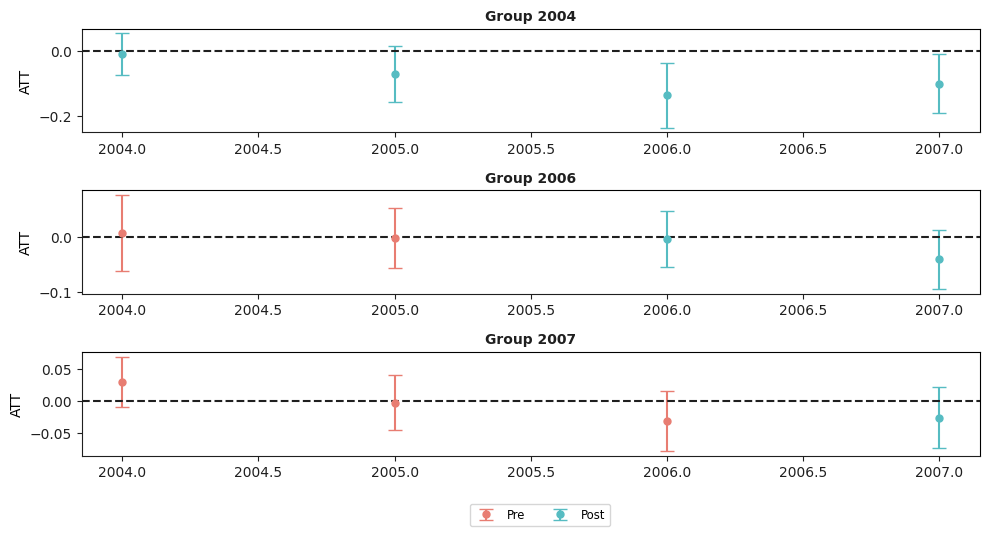

In [4]:
out.plot_attgt();